In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [3]:
MEAN = [0.4914, 0.4822, 0.4465]
STD = [0.2471, 0.2435, 0.2616]

DATA_ROOT = "./data/"
MODEL_ROOT = "./weight/"
IMAGE_ROOT = "./image/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

# 对训练数据进行图像增广，解决过拟合的问题。
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), # 随机翻转图片
    transforms.ToTensor(), # 数据集加载时，默认的图片格式是Numpy数组，所以需转换为Tensor。
    transforms.Normalize(mean=MEAN, std=STD)]) # 数据标准化

# 对测试数据标准化
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)])

# 训练集
trainset = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=True,
                                        download=True, transform=transform_train)

# 测试集
testset = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=False,
                                       download=True, transform=transform_test)

# 拆分数据集为数据和标签
def extract_dataset(dataset):
    x, y = zip(*dataset)
    x = torch.from_numpy(np.array([it.numpy() for it in x])).to(device)
    y = torch.tensor(y).to(device)
    return x, y

Files already downloaded and verified
Files already downloaded and verified


In [4]:
VGG_CONFIGS={
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "VGG19": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"]
}

losses = []
train_accs = []

class VGG(nn.Module):
    def __init__(self, vgg_name, class_num, epoch_num=10, learn_rate=0.001, batch_size=128):
        super(VGG, self).__init__()
        self.epoch_num = epoch_num
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.features = self.make_layers(VGG_CONFIGS[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, class_num)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def make_layers(self, configs):
        layers = []
        in_channels = 3
        for config in configs:
            if config == "M":
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                layers.append(nn.Conv2d(in_channels, config, kernel_size=3, padding=1))
                layers.append(nn.BatchNorm2d(config))
                layers.append(nn.ReLU(inplace=True))
                in_channels = config
        layers.append(nn.AvgPool2d(kernel_size=1, stride=1))
        return nn.Sequential(*layers)
    
    def train(self, dataset, save):
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        optimizer = optim.Adam(self.parameters(), lr=self.learn_rate)
        path = MODEL_ROOT + "weights.tar"
        init_epoch = 0

        if os.path.exists(path) is not True:
            loss = nn.CrossEntropyLoss()

        else:
            checkpoint = torch.load(path, map_location=torch.device(device))
            self.load_state_dict(checkpoint["model_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            init_epoch = checkpoint["epoch"] + 1
            loss = checkpoint["loss"]

        for epoch in range(init_epoch, self.epoch_num):
            print("Epoch %d/%d start." % (epoch + 1, self.epoch_num))
            timestart = time.time()
 
            batch_loss = 0.0
            total = 0
            correct = 0
            for i, data in enumerate(dataloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device),labels.to(device)
 
                optimizer.zero_grad()
 
                outputs = self(inputs)
                cur_loss = loss(outputs, labels)
                cur_loss.backward()
                optimizer.step()
 
                batch_loss += cur_loss.item()
              
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                if i % 100 == 99:
                    print("Epoch %d Step %d Loss: %.6f" % (epoch + 1, i + 1, batch_loss / 100))
                    batch_loss = 0.0
                    
            losses.append(batch_loss)
            train_acc = 100.0 * correct / total
            print("Train Accuracy: %.4f%%" % (train_acc))
            train_accs.append(train_acc)
            print("Epoch %d time cost %.3fs" % (epoch + 1, time.time()-timestart))
            
            if save:
                torch.save({"epoch": epoch,
                            "model_state_dict": self.state_dict(),
                            "optimizer_state_dict": optimizer.state_dict(),
                            "loss": loss
                            }, path)
 

        print("Finish %d epoch(s)." % self.epoch_num)
        
    def k_fold_cross_validation(self, k=5):
        num_train = len(trainset)
        index = list(range(num_train))
        
        num_valid = num_train // 5
        start_valid = 0
        accuracy = 0
        save = False
        for i in range(k):
            valid_idx = index[start_valid : start_valid + num_valid]
            train_idx = index[0 : start_valid] + index[start_valid + num_valid : ]
            start_valid += num_valid
            train_dataset = torch.utils.data.Subset(trainset, train_idx)
            valid_dataset = torch.utils.data.Subset(trainset, valid_idx)
            print("-"*10 + f" {i + 1} fold start " + "-"*10)
            if i + 1 == k:
                save = True
            self.train(train_dataset, save)
            valid_x, valid_y = extract_dataset(valid_dataset)
            accuracy += self.score(valid_x, valid_y)
            
        accuracy /= k
        print(f"{k} fold cross validation accuracy:{100 * accuracy:.4f}%")
        return accuracy
    
    @torch.no_grad
    def score(self, x, y):
        _, predict_y = torch.max(self(x), 1)
        return sum((predict_y == y)) / len(y)
    


In [5]:
CLASS_NUM = len(classes)
LEARN_RATE = 0.0001
BATCH_SIZE = 128
EPOCH_NUM = 6
net = VGG("VGG19", CLASS_NUM, epoch_num=EPOCH_NUM, learn_rate=LEARN_RATE, batch_size=BATCH_SIZE)
net = net.to(device)
net.k_fold_cross_validation()

---------- 1 fold start ----------
Finish 6 epoch(s).
---------- 2 fold start ----------
Finish 6 epoch(s).
---------- 3 fold start ----------
Finish 6 epoch(s).
---------- 4 fold start ----------
Finish 6 epoch(s).
---------- 5 fold start ----------
Finish 6 epoch(s).
5 fold cross validation accuracy:97.7160%


tensor(0.9772)

In [6]:
test_x, test_y = extract_dataset(testset)
print("Test Accuracy: %.4f%%" % (100.0 * net.score(test_x, test_y)))

Test Accuracy: 84.6200%


In [7]:
def save_list_to_file(lst, filename):
    with open(filename, "w") as file:
        for item in lst:
            file.write(str(item) + ", ")


def read_list_from_file(filename):
    with open(filename, "r") as file:
        line = file.readline()
        return list(map(float, line.split(", ")))

# save_list_to_file(losses, "loss.txt")
# save_list_to_file(train_accs, "accuracy.txt")

losses = np.array(read_list_from_file("loss.txt"))
train_accs = np.array(read_list_from_file("accuracy.txt"))

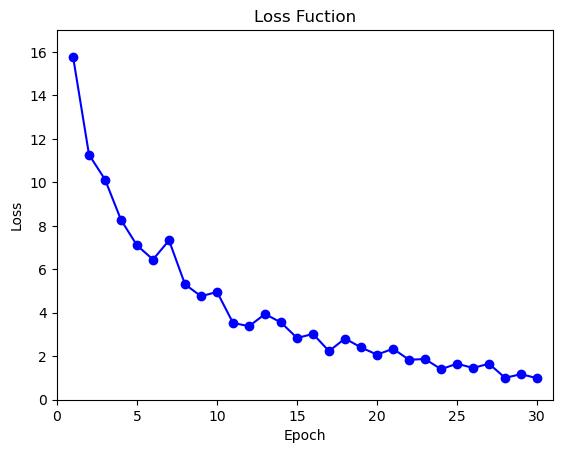

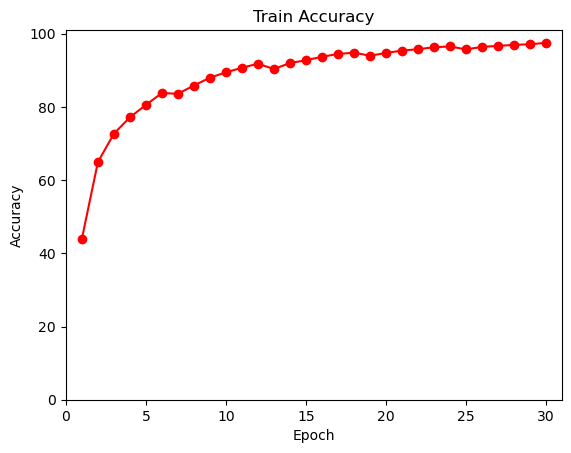

In [8]:
x = np.arange(1, losses.shape[0]+1)
plt.title("Loss Fuction")
plt.plot(x, losses, "bo-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(0, 31)
plt.ylim(0, 17)
plt.savefig(IMAGE_ROOT + "loss_fuction.jpg")
plt.show()

plt.title("Train Accuracy")
plt.plot(x, train_accs, "ro-")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim(0, 31)
plt.ylim(0, 101)
plt.savefig(IMAGE_ROOT + "train_accuracy.jpg")
plt.show()


In [9]:
showset = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=False,
                                       download=True)
show_x, show_y = zip(*showset)

Files already downloaded and verified


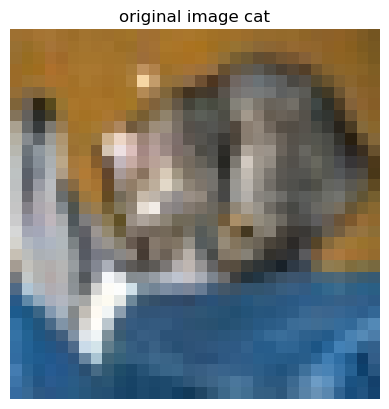

In [94]:
IMG_NUM = 0
SELECT_LAYER = [0, 2, 4, 8]
SAMPLE_STEP = 8
SAMPLE_NUM = 0

plt.axis("off")
plt.title("original image " + classes[show_y[IMG_NUM]])
plt.imshow(show_x[IMG_NUM])
plt.savefig(IMAGE_ROOT + "original_image_" + str(IMG_NUM) + ".jpg", bbox_inches="tight")


In [11]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [95]:
outputs = []
names = []
img = torch.unsqueeze(test_x[IMG_NUM], dim=0)
conv_cnt = 0
for i, layer in enumerate(net.modules()):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.ReLU) or isinstance(layer, nn.MaxPool2d) or isinstance(layer, nn.AvgPool2d):
        img = layer(img)
        if isinstance(layer, nn.Conv2d):
            if conv_cnt in SELECT_LAYER:
                print(layer)
                print(img.shape)
                names.append(str(layer).split(" ")[0] + str(layer).split(",")[1] + ")")
                outputs.append(img)
            conv_cnt += 1
    elif isinstance(layer, nn.Linear):
        break


Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 32, 32])
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 128, 16, 16])
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 256, 8, 8])
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 512, 4, 4])


In [60]:
outputs = []
names = []
img = torch.unsqueeze(test_x[IMG_NUM], dim=0)
conv_cnt = 0
for i, layer in enumerate(net.modules()):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.ReLU) or isinstance(layer, nn.MaxPool2d) or isinstance(layer, nn.AvgPool2d):
        img = layer(img)
        if isinstance(layer, nn.Conv2d):
            print(str(layer).split(" ")[0] + str(layer).split(",")[1] + ") Output", end="")
            print(img.squeeze(0).detach().numpy().shape)
            names.append(str(layer).split(" ")[0] + str(layer).split(",")[1] + ")")
            outputs.append(img)

    elif isinstance(layer, nn.Linear):
        break


Conv2d(3, 64) Output(64, 32, 32)
Conv2d(64, 64) Output(64, 32, 32)
Conv2d(64, 128) Output(128, 16, 16)
Conv2d(128, 128) Output(128, 16, 16)
Conv2d(128, 256) Output(256, 8, 8)
Conv2d(256, 256) Output(256, 8, 8)
Conv2d(256, 256) Output(256, 8, 8)
Conv2d(256, 256) Output(256, 8, 8)
Conv2d(256, 512) Output(512, 4, 4)
Conv2d(512, 512) Output(512, 4, 4)
Conv2d(512, 512) Output(512, 4, 4)
Conv2d(512, 512) Output(512, 4, 4)
Conv2d(512, 512) Output(512, 2, 2)
Conv2d(512, 512) Output(512, 2, 2)
Conv2d(512, 512) Output(512, 2, 2)
Conv2d(512, 512) Output(512, 2, 2)


In [97]:
samples = []

for output in outputs:
    output = output.squeeze(0).detach().numpy()
    sample = []
    for i in range(0, len(output), SAMPLE_STEP):
        sample.append(output[i])
    samples.append(sample)

samples


[[array([[-0.17527814, -0.19463643, -0.17582124, ..., -0.3722521 ,
          -0.4026019 , -0.35646755],
         [-0.22641207, -0.16726847, -0.13117762, ..., -0.239999  ,
          -0.26359475, -0.06658603],
         [-0.2507396 , -0.1803041 , -0.08916959, ..., -0.19529137,
          -0.2026263 , -0.06851624],
         ...,
         [-0.3516652 , -0.28104147, -0.18990076, ..., -0.4043977 ,
          -0.22271226,  0.46354395],
         [-0.36405778, -0.391629  , -0.21808586, ..., -0.4694137 ,
          -0.26720545,  0.40052193],
         [-0.25673756, -0.26240066, -0.13405204, ..., -0.32424483,
          -0.09729798,  0.02858111]], dtype=float32),
  array([[ 0.35611862,  0.50446254,  0.5244906 , ...,  0.2511828 ,
           0.1900376 , -0.01135488],
         [-0.13613519, -0.01479757, -0.01156276, ..., -0.07514705,
          -0.08140196,  0.03844264],
         [-0.09430198, -0.00112613,  0.04435754, ..., -0.06869654,
          -0.05565664,  0.01378892],
         ...,
         [ 0.004345

In [61]:
samples = []

for output in outputs:
    output = output.squeeze(0).detach().numpy()
    samples.append(output[SAMPLE_NUM])

for i in range(len(samples)):
    names[i] = names[i] + " Feature Map" + str(samples[i].shape)
    print(names[i])



Conv2d(3, 64) Feature Map(32, 32)
Conv2d(64, 64) Feature Map(32, 32)
Conv2d(64, 128) Feature Map(16, 16)
Conv2d(128, 128) Feature Map(16, 16)
Conv2d(128, 256) Feature Map(8, 8)
Conv2d(256, 256) Feature Map(8, 8)
Conv2d(256, 256) Feature Map(8, 8)
Conv2d(256, 256) Feature Map(8, 8)
Conv2d(256, 512) Feature Map(4, 4)
Conv2d(512, 512) Feature Map(4, 4)
Conv2d(512, 512) Feature Map(4, 4)
Conv2d(512, 512) Feature Map(4, 4)
Conv2d(512, 512) Feature Map(2, 2)
Conv2d(512, 512) Feature Map(2, 2)
Conv2d(512, 512) Feature Map(2, 2)
Conv2d(512, 512) Feature Map(2, 2)


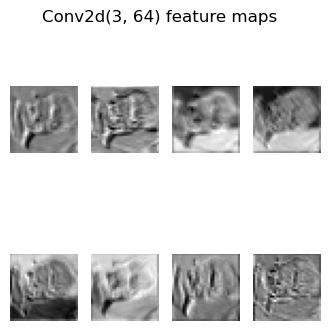

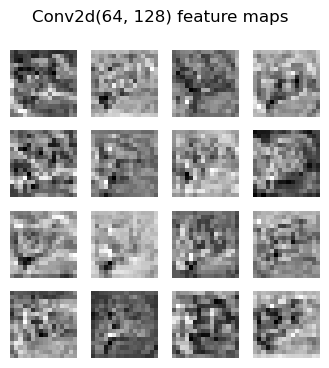

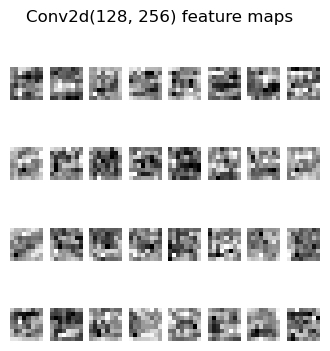

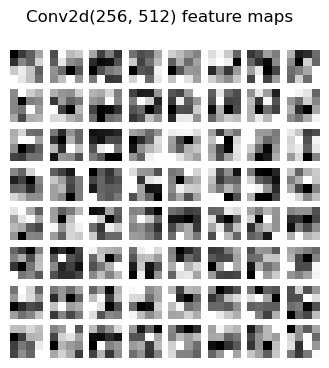

In [98]:
def visualize_feature_maps(sample, name):
    fig = plt.figure(figsize=(4, 4))
    fig.suptitle(name + " feature maps")
    sample_cnt = len(sample)
    row = 2
    if sample_cnt > 8 and sample_cnt <= 32:
        row = 4
    elif sample_cnt > 32:
        row = 8
    col = sample_cnt // row
    for i in range(sample_cnt):
        img = fig.add_subplot(row, col, i+1)
        img.axis("off")
        plt.imshow(sample[i], cmap="gray")
        plt.savefig(IMAGE_ROOT + name.replace(", ", "_") + "_feature_maps.jpg", bbox_inches="tight")

for sample, name in zip(samples, names):
    visualize_feature_maps(sample, name)


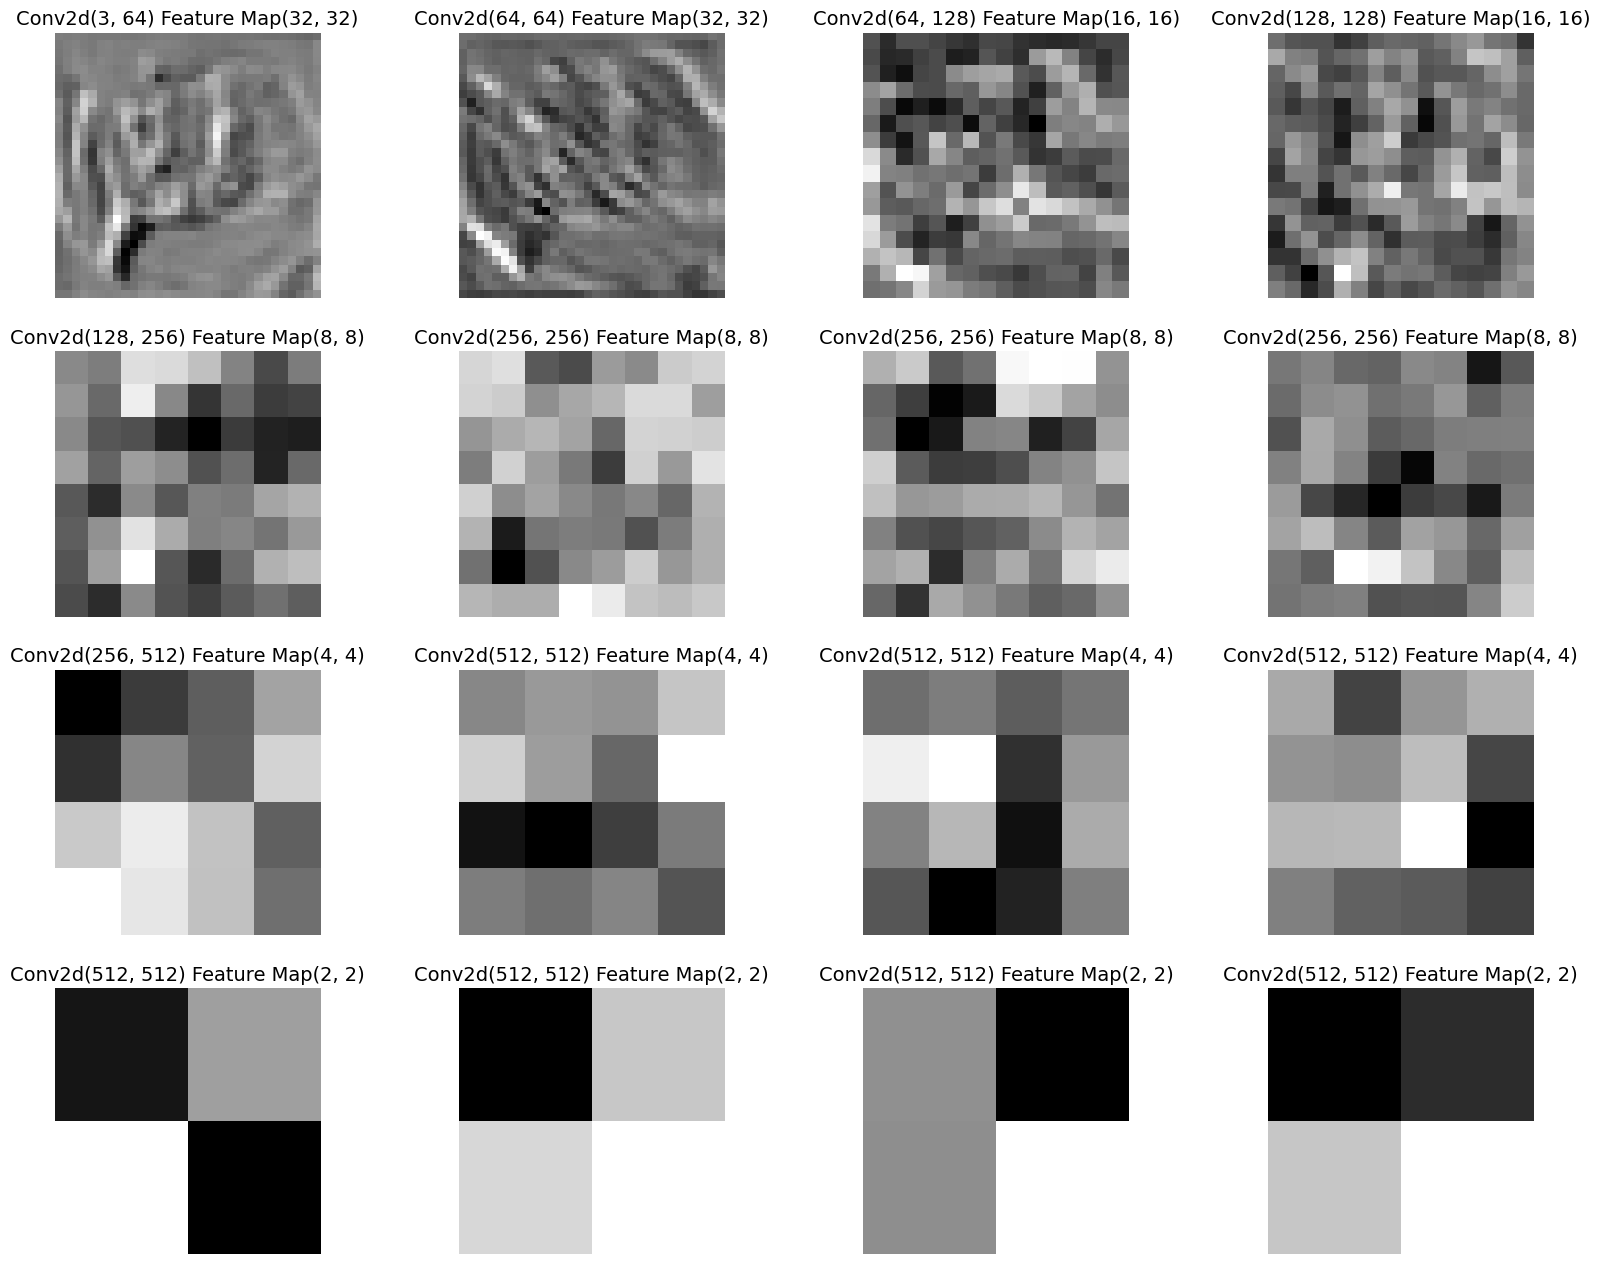

In [62]:
fig = plt.figure(figsize=(20, 20))

for i in range(len(samples)):
    a = fig.add_subplot(5, 4, i+1)
    img_plot = plt.imshow(samples[i], cmap="gray")
    a.axis("off")
    a.set_title(names[i], fontsize=14)

plt.savefig(IMAGE_ROOT + 'vgg19_feature_maps.jpg', bbox_inches='tight')
